In [45]:
import numpy as np 
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'serif','serif':['DejaVu Sans'],'size':14,'style':'normal'})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

c = 3e8
lam = 1064e-9
k = 2*np.pi/lam

def cav_response(omega, T, L, L_cav, omega_cav): 
    c = 3e8
    gamma = c*T/(4*L_cav)
    lam = c*L/(4*L_cav)
    return 1-(2*gamma)/(gamma+lam+1j*(omega-omega_cav))

def constrain(a):
    return (a+np.pi/2)%np.pi-np.pi/2

class FC: 
    def __init__(self,L_fc,f_fc,T,L,eta):
        self.L = L
        self.T = T
        self.L_fc = L_fc 
        self.f_fc = f_fc
        self.eta = eta 
    
    def fc_cav_response(self,f):
        cav = cav_response(2*np.pi*f, self.T, self.L, self.L_fc, 2*np.pi*self.f_fc)

        return cav
        
    def M_fc(self,f):
        ones = np.ones_like(f)
        zeros = np.zeros_like(f) 
        FC_p = self.eta*self.fc_cav_response(f)+(1-self.eta)
        FC_m = self.eta*np.conjugate(self.fc_cav_response(-f))+(1-self.eta)

        M_fc = np.array([[FC_p,zeros],[zeros,FC_m]])
        M_fc = M_fc.transpose(-1,0,1)
        return M_fc
    
    def m_qp(self,f):
        ones = np.ones_like(f)
        zeros = np.zeros_like(f) 
        FC_p = self.eta*self.fc_cav_response(f)+(1-self.eta)
        FC_m = self.eta*np.conjugate(self.fc_cav_response(-f))+(1-self.eta)
        
        m_qp = 1/2*np.array([[1j*(FC_m-FC_p)],[FC_p+FC_m]])
        
class AdaptiveFC:
    def __init__(self,L,det_f,r,t,FC):
        self.r = r 
        self.t = t
        self.det_f = det_f 
        self.FC = FC 
        self.L = L
    def freq_response(self,f):
        return (self.r-(self.t**2*self.FC.fc_cav_response(f)*np.exp(-4*np.pi*1j*self.L*(self.det_f+f)/c))/(1-self.r*self.FC.fc_cav_response(f)*np.exp(-4*np.pi*1j*self.L*(self.det_f+f)/c)))

In [102]:
Apl = FC(L_fc = 297, f_fc =1000, T = 909e-6,L =10e-6,eta = 1)
L = 0.1

r = 0.2
l = 100e-6
t = np.sqrt(1-r**2-l)
dp = np.linspace(0,1,500)
Det_f = dp*c/(2*L)


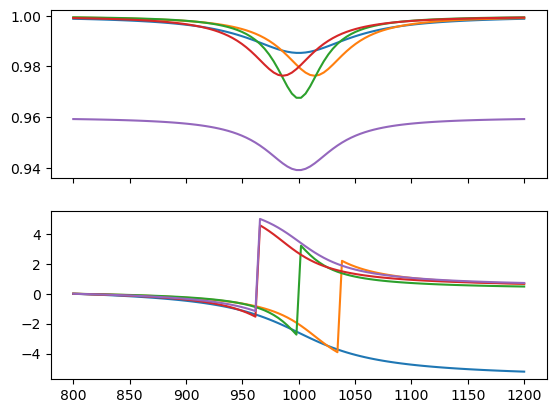

In [3]:
fig,[ax1,ax2] = plt.subplots(2,1,sharex = True)

for det_f in Det_f:
    ad_fc = AdaptiveFC(L,det_f,r,t,Apl)
    f = np.linspace(800,1200,100)
    r_ad = ad_fc.freq_response(f)
 
    ax1.plot(f,np.abs(r_ad))
    ax2.plot(f,np.angle(r_ad)-np.angle(r_ad[0]))
    
    
ad_fc = AdaptiveFC(L,det_f,0,t,Apl)
f = np.linspace(800,1200,100)
r_ad = ad_fc.freq_response(f)

ax1.plot(f,np.abs(r_ad))
ax2.plot(f,np.angle(r_ad)-np.angle(r_ad[0]))


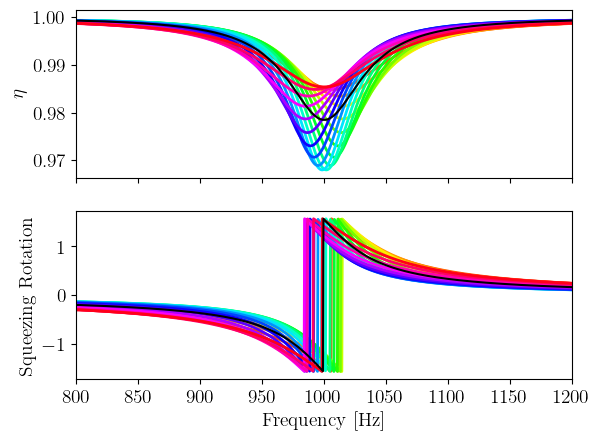

In [99]:
fig,[ax1,ax2] = plt.subplots(2,1,sharex = True)
colors = plt.cm.hsv(np.linspace(0, 1, len(Det_f)))
bandw = []
dets = []
max_l = []
for c1,det_f in zip(colors,Det_f):
    ad_fc = AdaptiveFC(L,det_f,r,t,Apl)
    f = np.linspace(800,1200,1000)
    f[0] = -10000
    r_ad = ad_fc.freq_response(f)
    mp = (ad_fc.freq_response(f)+np.conjugate(ad_fc.freq_response(-f)))/2
    mq = -1j*(ad_fc.freq_response(f)-np.conjugate(ad_fc.freq_response(-f)))/2
    eff = np.abs(mp)**2+np.abs(mq)**2
    rot = 1/2*np.angle((mp+1j*mq)/(mp-1j*mq))
 
    ax1.plot(f,eff,color = c1,alpha = 1,linewidth = 2)
    
    ax2.plot(f,constrain(rot-rot[0]),color = c1,alpha = 1,linewidth = 2)
    f_hb1 = np.argmin(np.abs(constrain(rot-rot[0])-np.pi/4))
    f_hb2 = np.argmin(np.abs(constrain(rot-rot[0])+np.pi/4))
    bandw.append(((f[f_hb1]-f[f_hb2])/2))
    det = f[np.argmin(np.abs(constrain(rot-rot[0])+np.pi/2))]
    dets.append(det)
    max_l.append(np.min(eff))
ad_fc = AdaptiveFC(L,det_f,0,1,Apl)
f = np.linspace(800,1200,1000)
f[0] = -40000
r_ad = ad_fc.freq_response(f)
mp = (ad_fc.freq_response(f)+np.conjugate(ad_fc.freq_response(-f)))/2
mq = -1j*(ad_fc.freq_response(f)-np.conjugate(ad_fc.freq_response(-f)))/2
eff = np.abs(mp)**2+np.abs(mq)**2
rot = 1/2*np.angle((mp+1j*mq)/(mp-1j*mq))

ax1.plot(f,eff,'k')
ax2.plot(f,constrain(rot-rot[0]),'k')
ax1.set_xlim([800,1200])
f_hb1 = np.argmin(np.abs(constrain(rot-rot[0])-np.pi/4))
f_hb2 = np.argmin(np.abs(constrain(rot-rot[0])+np.pi/4))
b1 = ((f[f_hb1]-f[f_hb2])/2)
det1 = f[np.argmin(np.abs(constrain(rot-rot[0])+np.pi/2))]
l1 = np.min(eff)


ax2.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('$\eta$')
ax2.set_ylabel('Squeezing Rotation')
plt.savefig('tunability.pdf')

ValueError: x and y must have same first dimension, but have shapes (500,) and (20,)

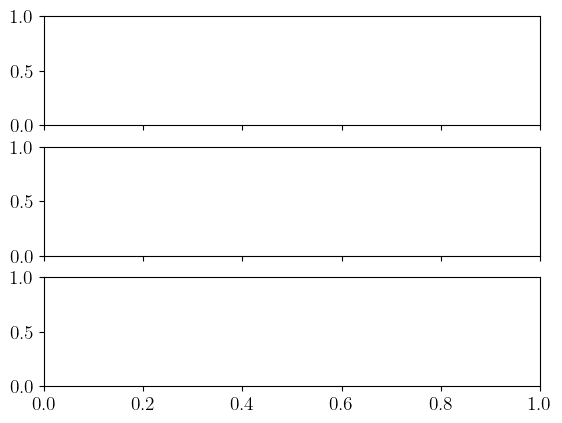

In [101]:
fig,[ax1,ax2,ax3] = plt.subplots(3,1,sharex = True)

ax1.plot(dp,b1*np.ones(len(bandw)),'k')
ax2.plot(dp,0*np.ones(len(bandw)),'k')
ax3.plot(dp,l1*np.ones(len(bandw)),'k')
ax1.scatter(dp,bandw,cmap = 'hsv',c = dp*100,s=2)
ax2.scatter(dp,dets-det1,cmap = 'hsv',c = dp*100,s=2)
ax3.scatter(dp,max_l,cmap = 'hsv',c = dp*100,s=2)
ax3.set_xlabel('Relative Detuning')
ax1.set_ylabel('Cavity Pole [Hz]')
ax2.set_ylabel('Detuning Error [Hz]')
ax3.set_ylabel('$\eta$')
plt.savefig('tune_range.pdf')



In [52]:
Det_f

array([0.000e+00, 3.750e+08, 7.500e+08, 1.125e+09])

In [54]:
colors[0]

array([0.5, 0. , 1. , 1. ])

In [56]:
for det_f,c in zip(Det_f,colors):
    print(det_f,c)

0.0 [0.5 0.  1.  1. ]
375000000.0 [0.16666667 0.8660254  0.8660254  1.        ]
750000000.0 [0.83333333 0.8660254  0.5        1.        ]
1125000000.0 [1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00]


In [5]:
np.angle((1-1j)/(1+1j))

-1.5707963267948966

In [7]:
np.angle((1+1j))

0.7853981633974483

In [8]:
(1-1j)**2

-2j

In [10]:
np.arctan(2)

1.1071487177940906